# Libraries

In [3]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from textblob import TextBlob

from os.path import exists
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_predict


from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

import optuna
from optuna.samplers import TPESampler


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

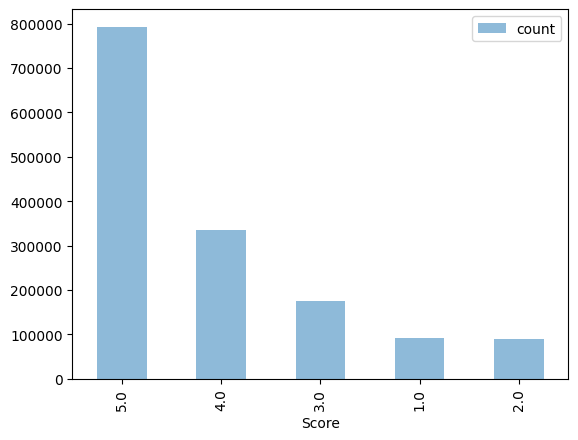


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [143]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print(trainingSet.columns.values)
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

# trainingSet = trainingSet[:10000]
# trainingSet.to_csv("./data/X_train_fresh.csv", index=False)

# Make sure to comment this when submitting
# trainingSet = trainingSet[:10000]

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [144]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer


def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Calculate the length of the review text
    df['ReviewLength'] = df['Text'].fillna('').apply(len)

    # Calculate the length of the summary text
    df['SummaryLength'] = df['Summary'].fillna('').apply(len)
    
    # Sentiment analysis on review text
    df['TextPolarity'] = df['Text'].fillna('').apply(lambda x: TextBlob(x).sentiment.polarity)
    df['TextSubjectivity'] = df['Text'].fillna('').apply(lambda x: TextBlob(x).sentiment.subjectivity)

    # Word count in the review text
    df['WordCount'] = df['Text'].fillna('').apply(lambda x: len(x.split()))

    # Extract temporal features from Time column
    df['ReviewYear'] = pd.to_datetime(df['Time'], unit='s').dt.year
   
    # Interaction feature between review length and text polarity
    df['LengthPolarityInteraction'] = df['ReviewLength'] * df['TextPolarity']
    
    # 9. Log transformations for skewed features
    df['ReviewLength_log'] = np.log1p(df['ReviewLength'])
    df['WordCount_log'] = np.log1p(df['WordCount'])

    # 10. Aggregates by ProductId and UserId (averages as numeric values)
    df['UserAverageScore'] = df.groupby('UserId')['Score'].transform('mean')
    df['ProductAverageScore'] = df.groupby('ProductId')['Score'].transform('mean')
    
    # Fill missing values for new users or products with the overall average
    df['UserAverageScore'] = df['UserAverageScore'].fillna(df['Score'].mean())
    df['ProductAverageScore'] = df['ProductAverageScore'].fillna(df['Score'].mean())
    
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train3.csv'):
    X_train = pd.read_csv("./data/X_train2.csv")
if exists('./data/X_submission3.csv'):
    X_submission = pd.read_csv("./data/X_submission2.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    print(train.columns.values)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission_crazy.csv", index=False)
    X_train.to_csv("./data/X_train_crazy.csv", index=False)

['Id' 'ProductId' 'UserId' 'HelpfulnessNumerator' 'HelpfulnessDenominator'
 'Time' 'Summary' 'Text' 'Score' 'Helpfulness' 'ReviewLength'
 'SummaryLength' 'TextPolarity' 'TextSubjectivity' 'WordCount'
 'ReviewYear' 'LengthPolarityInteraction' 'ReviewLength_log'
 'WordCount_log' 'UserAverageScore' 'ProductAverageScore']


# Sample + Split into training and testing set

In [145]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [146]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV

features = [
    'HelpfulnessNumerator', 
    'HelpfulnessDenominator', 
    'Time', 
    'Helpfulness',                  # Ratio of Helpfulness
    'ReviewLength',                 # Length of review text
    'SummaryLength',                # Length of summary text
    'TextPolarity',                 # Sentiment polarity of the review text
    'TextSubjectivity',             # Sentiment subjectivity of the review text
    'WordCount',                    # Word count of the review text
    'ReviewYear',                   # Year the review was posted 
    # new from here
    'LengthPolarityInteraction',    # Interaction between review length and polarity
    'WordCount_log',                # Log-transformed word count
    'UserAverageScore',             # Average score per user
    'ProductAverageScore'           # Average score per product
]

# Adding TF-IDF columns to the features list
# tfidf_features = [f'tfidf_{i}' for i in range(100)]  # Assuming max_features=100 for TF-IDF
# features.extend(tfidf_features)

print(X_train.columns.values)

    
X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Standardize the features to ensure Lasso works effectively
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_select)
X_test_scaled = scaler.transform(X_test_select)

# Apply LassoCV to determine the best alpha (regularization strength) and fit the model
lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, Y_train)

# Identify non-zero coefficient features
selected_features = [feature for feature, coef in zip(features, lasso.coef_) if coef != 0]
print(len(selected_features))
print("Selected features after Lasso:", selected_features)

# Update the feature sets to include only the selected features
X_train_select = X_train_select[selected_features]
X_test_select = X_test_select[selected_features]
X_submission_select = X_submission_select[selected_features]

print("Updated X_train_select, X_test_select, and X_submission_select with Lasso-selected features.")



['Id' 'ProductId' 'UserId' 'HelpfulnessNumerator' 'HelpfulnessDenominator'
 'Time' 'Summary' 'Text' 'Helpfulness' 'ReviewLength' 'SummaryLength'
 'TextPolarity' 'TextSubjectivity' 'WordCount' 'ReviewYear'
 'LengthPolarityInteraction' 'ReviewLength_log' 'WordCount_log'
 'UserAverageScore' 'ProductAverageScore']
11
Selected features after Lasso: ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'TextPolarity', 'TextSubjectivity', 'WordCount', 'LengthPolarityInteraction', 'WordCount_log', 'UserAverageScore', 'ProductAverageScore']
Updated X_train_select, X_test_select, and X_submission_select with Lasso-selected features.


# Model Creation

In [141]:
# Learn the model

# number_of_neighbors = range(20,50)
# for neighbor in number_of_neighbors:
#     knn_model = KNeighborsClassifier(neighbor).fit(X_train_select, Y_train)
#     Y_test_predictions = knn_model.predict(X_test_select)
#     print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
#     print("neighbor is ", neighbor)

# Initialize the LightGBM classifier
    
# Define the objective function for Bayesian Optimization
def objective(trial):
    # Define the parameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50)
    }

    # Initialize the LightGBM model with trial-specific parameters
    lgbm_model = LGBMClassifier(**params, random_state=0)
    
    # Train the model
    lgbm_model.fit(X_train_select, Y_train)
    
    # Predict on validation set
    Y_test_predictions = lgbm_model.predict(X_test_select)
    
    # Calculate accuracy
    accuracy = accuracy_score(Y_test, Y_test_predictions)
    return accuracy

# # Run Bayesian optimization
# study = optuna.create_study(direction='maximize', sampler=TPESampler())
# study.optimize(objective, n_trials=50)  # Number of trials can be adjusted

# # Output the best parameters and accuracy score
# print("Best parameters found by Optuna:")
# print(study.best_trial.params)
# print(f"Best accuracy: {study.best_trial.value:.2f}")


# lgbm_model = LGBMClassifier(
#     n_estimators=888,           # Start with a high number of estimators
#     learning_rate=0.016486206098036624,         # Lower learning rate for better accuracy
#     max_depth=10,                # Control the depth of the trees
#     num_leaves=36,              # Control the number of leaves
#     subsample=0.5876457482520973,              # Row subsampling to prevent overfitting
#     colsample_bytree=0.5948404239217249,       # Column subsampling to prevent overfitting
#     min_child_samples=42,       # Minimum number of samples per leaf
#     random_state=0,
#     verbose=-1
# ).fit(X_train_select, Y_train)


# Define the parameter grid for LightGBM
# param_grid = {
#     'num_leaves': [31, 50, 70],
#     'learning_rate': [0.1, 0.01],
#     'max_depth': [-1, 10, 20],
#     'feature_fraction': [0.8, 1.0],
#     'bagging_fraction': [0.8, 1.0],
#     'bagging_freq': [5, 10]
# }

# # Initialize the LightGBM classifier
# lgbm = LGBMClassifier(random_state=42)

# # Set up GridSearchCV with 3-fold cross-validation
# grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# # Fit the grid search on the training set
# grid_search.fit(X_train_select, Y_train)

# # Best model after tuning
# best_lgbm_model = grid_search.best_estimator_
# print("Best parameters found: ", grid_search.best_params_)

# # Evaluate the tuned model on the validation set
# Y_test_predictions = best_lgbm_model.predict(X_test_select)

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier\




# Step 1: Tune Hyperparameters for Base Models
# Example hyperparameter tuning for RandomForest

rf_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
rf_search = GridSearchCV(RandomForestClassifier(), rf_grid, cv=3, scoring='accuracy')
rf_search.fit(X_train_select, Y_train)
best_rf = rf_search.best_estimator_


# base_estimators = {
#     'Random Forest': best_rf,  # Use the best RF model from previous tuning
#     'LightGBM': LGBMClassifier(
#         n_estimators=888,
#         learning_rate=0.016486206098036624,
#         max_depth=10,
#         num_leaves=36,
#         subsample=0.5876457482520973,
#         colsample_bytree=0.5948404239217249,
#         min_child_samples=42,
#         random_state=0,
#         verbose=-1
#     ),
#     'SVC': SVC(probability=True),
#     'Logistic Regression': LogisticRegression(max_iter=1000),
#     'KNN': KNeighborsClassifier(n_neighbors=32)
# }
# accuracies = {}

# for name, model in base_estimators.items():
#     model.fit(X_train_select, Y_train)  # Train the model
#     y_pred = model.predict(X_test_select)  # Predict on the test set
#     accuracy = accuracy_score(Y_test, y_pred)  # Calculate accuracy
#     accuracies[name] = accuracy  # Store accuracy in dictionary
#     print(f"{name} Accuracy: {accuracy:.4f}")
base_estimators = [
    ('rf', best_rf),
    ('lgbm', LGBMClassifier(
    n_estimators=888,           # Start with a high number of estimators
    learning_rate=0.016486206098036624,         # Lower learning rate for better accuracy
    max_depth=10,                # Control the depth of the trees
    num_leaves=36,              # Control the number of leaves
    subsample=0.5876457482520973,              # Row subsampling to prevent overfitting
    colsample_bytree=0.5948404239217249,       # Column subsampling to prevent overfitting
    min_child_samples=42,       # Minimum number of samples per leaf
    random_state=0,
    verbose=-1)),
    ('svc', SVC(probability=True)),
    ('logreg', LogisticRegression(max_iter=1000)), 
    ('knn', KNeighborsClassifier(n_neighbors=32))
]
stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=1000),  # You can change this to other meta-models if desired
    cv=5  # 5-fold cross-validation within the stacking
)
stacking_model.fit(X_train_select, Y_train)

# voting_clf = VotingClassifier(
#     estimators=base_estimators2,
#     voting='hard'  # Hard voting for majority vote
# )

# # Fit and predict
# voting_clf.fit(X_train_select, Y_train)
#     # Predict the score using the model


Y_test_predictions = stacking_model.predict(X_test_select)
    



# Model Evaluation

Accuracy on testing set =  0.9496


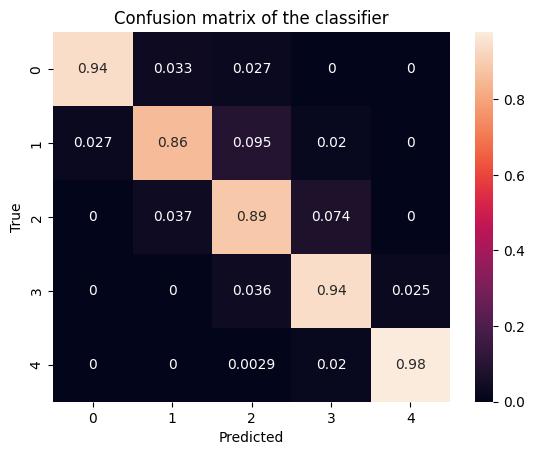

In [142]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# 5651

# Create submission file

In [143]:
# Create the submission file

X_submission['Score'] = lgbm_model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)